In [1]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torchvision import transforms
from tqdm import *
import matplotlib.pyplot as plt
import pickle
import random

In [2]:
# DEFINE NETWORK
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # my network is composed of only affine layers
        self.fc1 = nn.Linear(28*28, 300)
        self.fc2 = nn.Linear(300, 100)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def classify(self, x):
        outputs = self.forward(x)
        outputs = outputs / torch.norm(outputs)
        max_val, max_idx = torch.max(outputs, 1)
        return int(max_idx.data.numpy()), float(max_val.data.numpy())

net = Net()
print(net)
SoftmaxWithXent = nn.CrossEntropyLoss()

# Load pre-trained weights
weights_dict = {}
with open("weights.pkl", "rb") as f:
    weights_dict = pickle.load(f)
for param in net.named_parameters():
    if param[0] in weights_dict.keys():
        print("Copying: ", param[0])
        param[1].data = weights_dict[param[0]].data
print("Weights Loaded!")

# Load 5K samples
with open("5k_samples.pkl","rb") as f:
    samples_5k = pickle.load(f)

Net(
  (fc1): Linear(in_features=784, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)
Copying:  fc1.weight
Copying:  fc1.bias
Copying:  fc2.weight
Copying:  fc2.bias
Copying:  fc3.weight
Copying:  fc3.bias
Weights Loaded!


In [9]:
xs = samples_5k["images"]
y_trues = samples_5k["labels"]
adv_acu = []
noise_set = []
for eps in range(1, 31):
    y_preds = []
    noises = []
    y_preds_outputs = []
    y_preds_adversarial = []
    for x, y_true in tqdm(zip(xs, y_trues)):
        # Wrap x as a variable
        x = Variable(torch.FloatTensor(x.reshape(1,784)), requires_grad=True)
        y_true = Variable(torch.LongTensor(np.array([y_true])), requires_grad=False)

        # Classification before Adv
        y_pred =  np.argmax(net(x).data.numpy())

        # Generate Adversarial Image

        # Forward pass
        outputs = net(x)
        loss = SoftmaxWithXent(outputs, y_true)
        loss.backward() # obtain gradients on x

        # Add perturbation
        epsilon = 0.01 * eps
        x_grad   = torch.sign(x.grad.data)
        x_adversarial = torch.clamp(x.data + epsilon * x_grad, 0, 1)

        # Classification after optimization
        y_pred_outputs = net(Variable(x_adversarial)).data.numpy()
        y_pred_adversarial = np.argmax(net(Variable(x_adversarial)).data.numpy())
        # print "Before: {} | after: {}".format(y_pred, y_pred_adversarial)

        # print "Y_TRUE: {} | Y_PRED: {}".format(_y_true, y_pred)
        if y_true.data.numpy() != y_pred:
            pass
            # print("WARNING: MISCLASSIFICATION ERROR")
            # totalMisclassifications += 1
        else:
            y_preds.append(y_pred)
            y_preds_outputs.append(y_pred_outputs)
            y_preds_adversarial.append(y_pred_adversarial)
            noises.append( (x_adversarial - x.data).numpy() )
    noise_set.append(noises)
    len_pred = len(y_preds)
    cnt = 0
    for i in range(len_pred):
        if y_preds[i] == y_preds_adversarial[i]:
            cnt += 1
    adv_acu.append(cnt / len_pred)

5000it [00:05, 845.77it/s]
5000it [00:06, 776.57it/s]
5000it [00:06, 720.88it/s]
5000it [00:06, 739.03it/s]
5000it [00:07, 703.37it/s]
5000it [00:06, 796.24it/s]
5000it [00:07, 631.76it/s]
5000it [00:06, 771.79it/s]
5000it [00:06, 742.68it/s]
5000it [00:06, 756.01it/s]
5000it [00:05, 845.02it/s]
5000it [00:06, 826.15it/s]
5000it [00:07, 706.10it/s]
5000it [00:06, 820.67it/s]
5000it [00:07, 650.48it/s]
5000it [00:07, 687.52it/s]
5000it [00:07, 693.70it/s]
5000it [00:06, 749.32it/s]
5000it [00:08, 623.32it/s]
5000it [00:07, 686.19it/s]
5000it [00:06, 793.57it/s]
5000it [00:06, 815.27it/s]
5000it [00:08, 577.40it/s]
5000it [00:08, 603.94it/s]
5000it [00:07, 673.80it/s]
5000it [00:07, 640.20it/s]
5000it [00:08, 602.59it/s]
5000it [00:07, 658.00it/s]
5000it [00:07, 691.52it/s]
5000it [00:05, 851.58it/s]


In [18]:
import numpy.linalg as la
noise_norm_2 = []
noise_norm_inf = []
print(len(noise_set[0]))
for i in range(30):
    tarr = np.zeros(784)
    for j in range(4827):
        for k in range(784):
            tarr[k] += noise_set[i][j][0][k]
    for k in range(784):
        tarr[k] /= 4827
    tin = tarr.reshape(28, 28)
    noise_norm_2.append(la.norm(tin, 2))
    noise_norm_inf.append(la.norm(tin, np.inf))
    # noise_norm_2.append(la.norm(noise_set[i], 2))
    # noise_norm_inf.append(la.norm(noise_set[i], np.inf))

4827


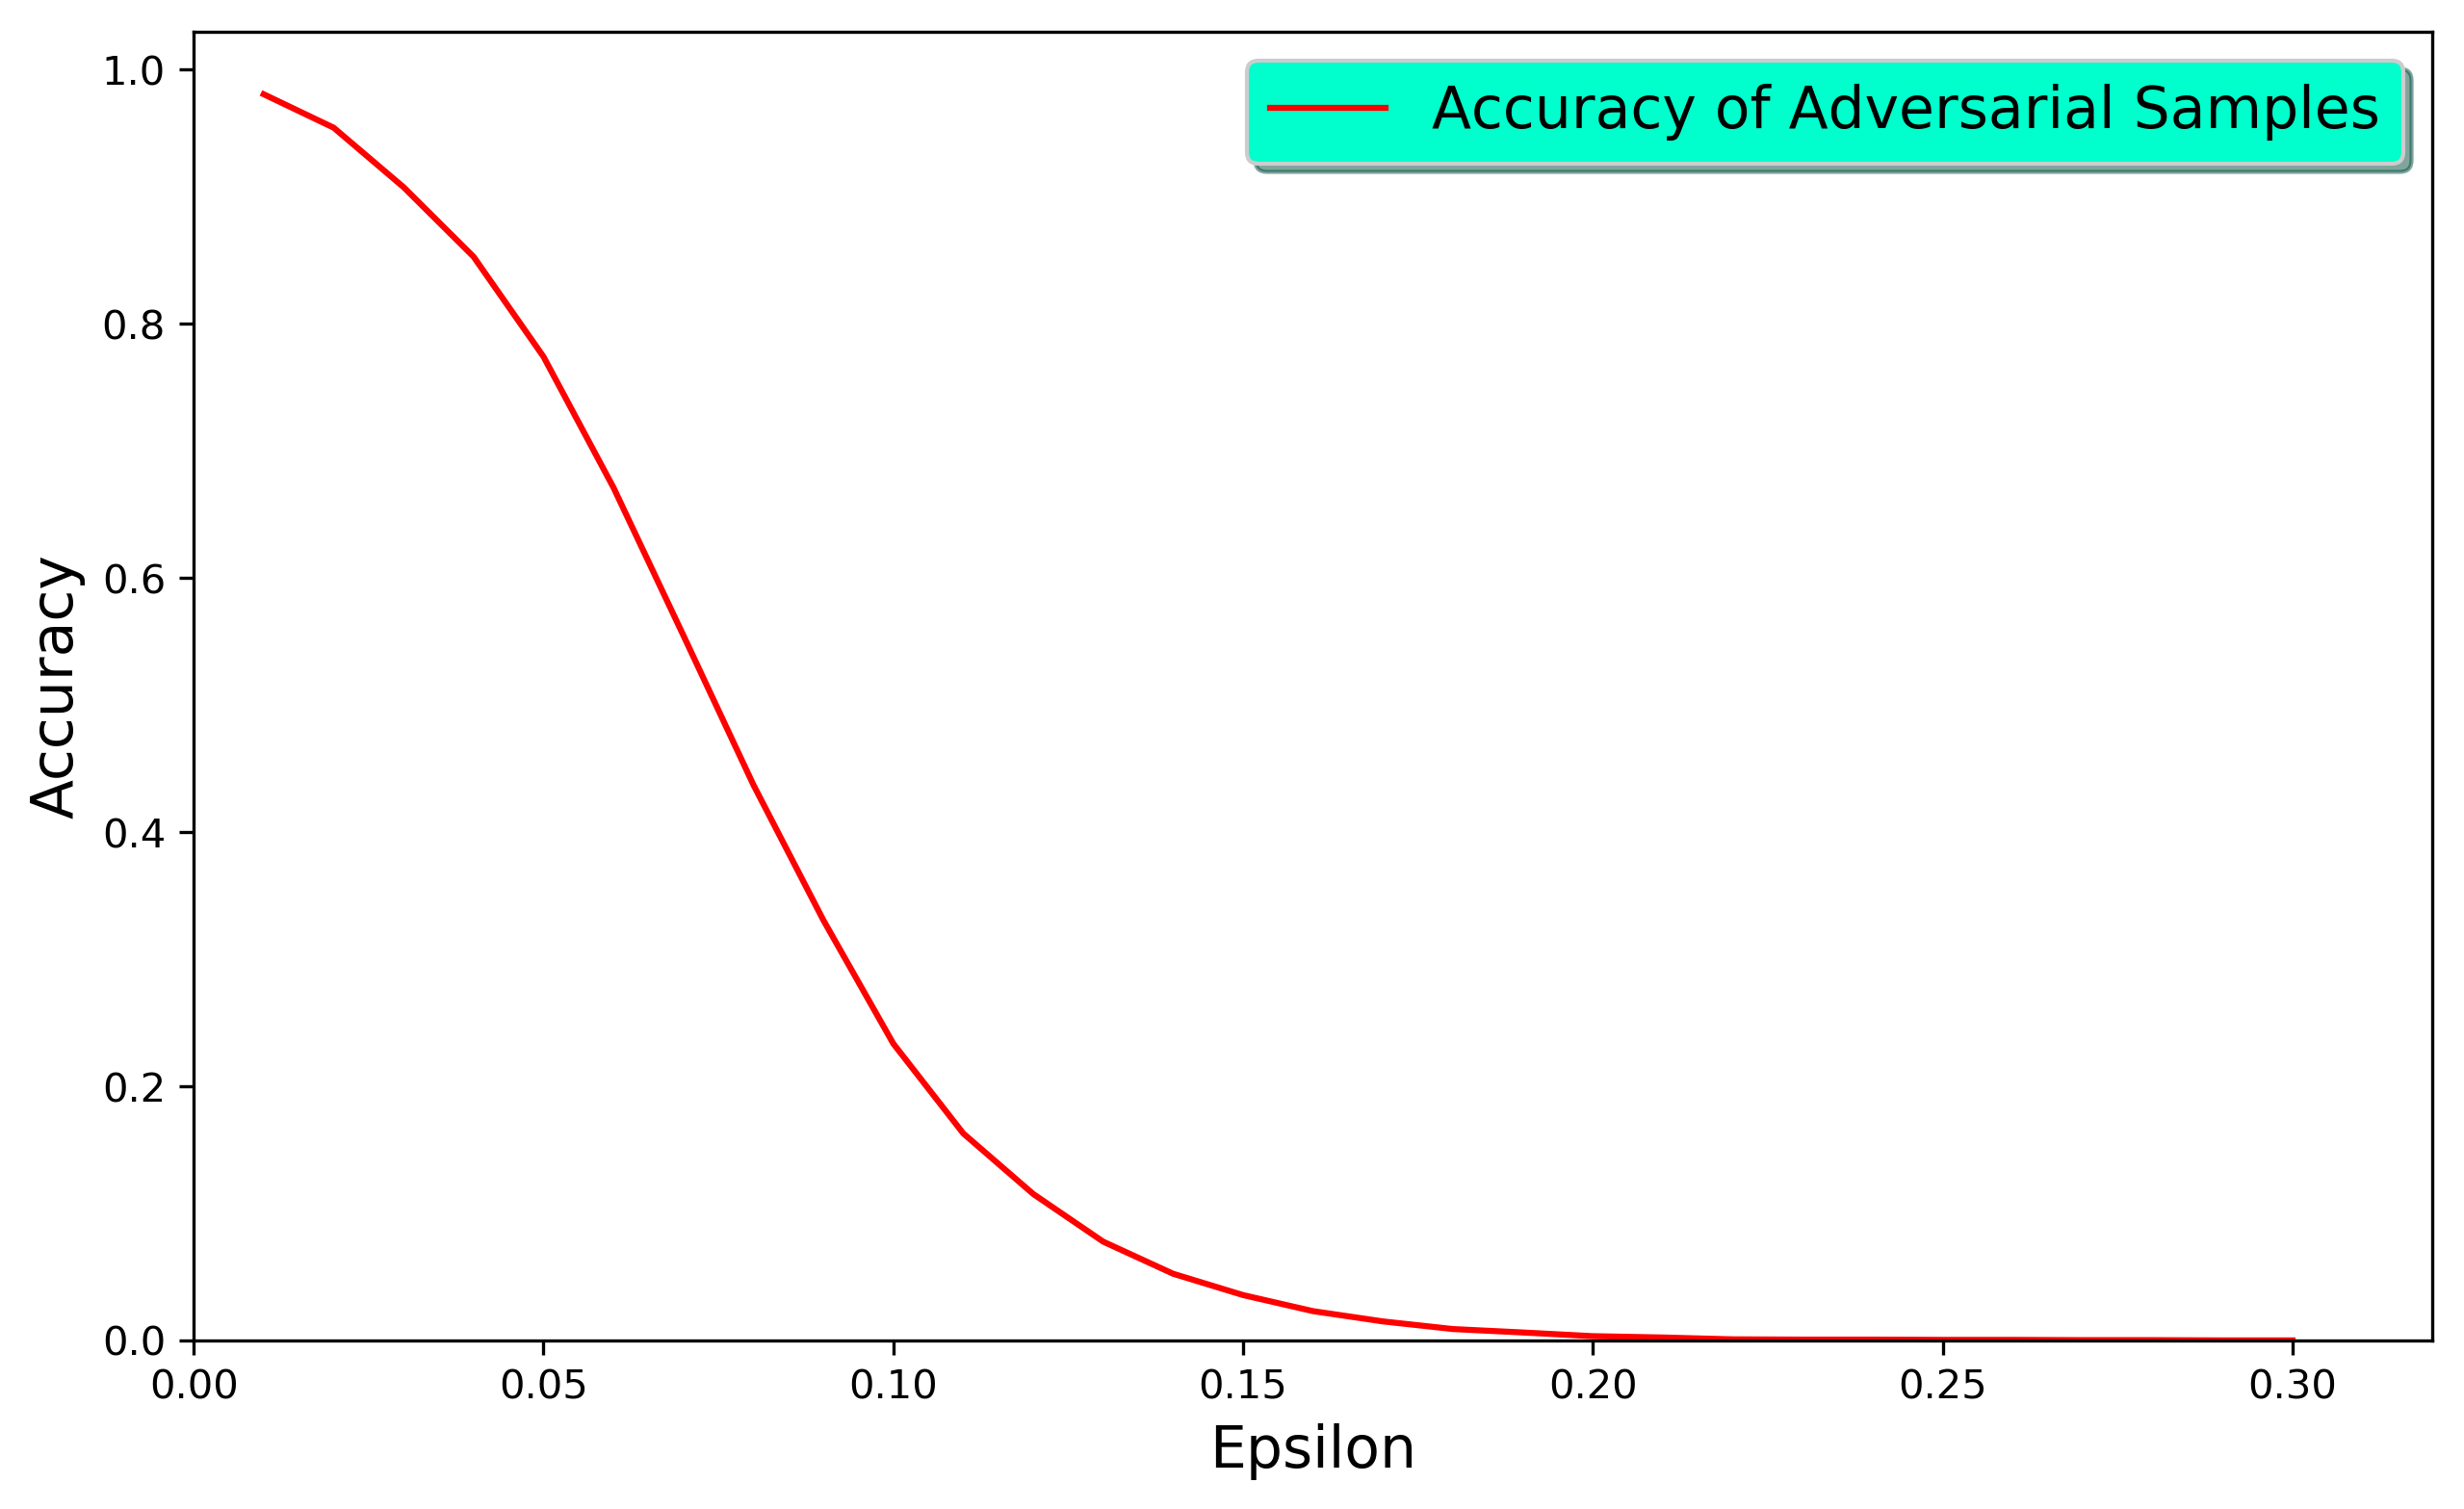

In [23]:
x_axis = np.linspace(0.01, 0.3, 30)

fig_kw = {'figsize':(10,6), 'dpi':300}

fig, ax = plt.subplots(**fig_kw)

ax.plot(x_axis, adv_acu, 'r-', label='Accuracy of Adversarial Samples')
# ax.plot(x_axis, noise_norm_2, 'g-', label='Norm_2')
# ax.plot(x_axis, noise_norm_inf, 'r-', label='Norm_inf')

plt.xlim(0, 0.32)
plt.ylim(ymin=0)
plt.xlabel('Epsilon', fontsize='x-large')
plt.ylabel('Accuracy', fontsize='x-large')

legend = ax.legend(shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('#00FFCC')

plt.show()

In [24]:
noises = []
y_preds = []
y_oris_outputs = []
y_preds_outputs = []
y_preds_adversarial = []
xs_clean = []
y_trues_clean = []

for x, y_true in tqdm(zip(xs, y_trues)):

    # Wrap x as a variable
    x = Variable(torch.FloatTensor(x.reshape(1,784)), requires_grad=True)
    y_true = Variable(torch.LongTensor(np.array([y_true])), requires_grad=False)

    # Classification before Adv
    y_ori_outputs = net(x).data.numpy()
    y_pred =  np.argmax(net(x).data.numpy())

    # Generate Adversarial Image

    # Forward pass
    outputs = net(x)
    loss = SoftmaxWithXent(outputs, y_true)
    loss.backward() # obtain gradients on x

    # Add perturbation
    epsilon = 0.1
    x_grad   = torch.sign(x.grad.data)
    x_adversarial = torch.clamp(x.data + epsilon * x_grad, 0, 1)

    # Classification after optimization
    y_pred_outputs = net(Variable(x_adversarial)).data.numpy()
    y_pred_adversarial = np.argmax(net(Variable(x_adversarial)).data.numpy())
    # print "Before: {} | after: {}".format(y_pred, y_pred_adversarial)

    # print "Y_TRUE: {} | Y_PRED: {}".format(_y_true, y_pred)
    if y_true.data.numpy() != y_pred:
        pass
        # print("WARNING: MISCLASSIFICATION ERROR")
        # totalMisclassifications += 1
    else:
        y_preds.append(y_pred)
        y_oris_outputs.append(y_ori_outputs)
        y_preds_outputs.append(y_pred_outputs)
        y_preds_adversarial.append(y_pred_adversarial)
        noises.append( (x_adversarial - x.data).numpy() )
        xs_clean.append(x.data.numpy())
        y_trues_clean.append(y_true.data.numpy())

5000it [00:07, 649.95it/s]


In [30]:
idx = 15
# print(y_preds[idx])
# print(y_preds_adversarial[idx])
import math
sum = 0.
for tmp in y_preds_outputs[idx][0]:
    sum += math.exp(tmp)
y_prob = []
for tmp in y_preds_outputs[idx][0]:
    y_prob.append(math.exp(tmp) / sum)
for i in range(10):
    print("Probability of %d %8.3f %%" % (i, 100. * y_prob[i]))

Probability of 0    0.003 %
Probability of 1    1.663 %
Probability of 2    1.030 %
Probability of 3   17.553 %
Probability of 4   61.177 %
Probability of 5    1.264 %
Probability of 6    0.119 %
Probability of 7    1.484 %
Probability of 8   12.460 %
Probability of 9    3.247 %


In [31]:
sum = 0.
for tmp in y_oris_outputs[idx][0]:
    sum += math.exp(tmp)
y_prob = []
for tmp in y_oris_outputs[idx][0]:
    y_prob.append(math.exp(tmp) / sum)
for i in range(10):
    print("Probability of %d %8.3f %%" % (i, 100. * y_prob[i]))

Probability of 0    0.000 %
Probability of 1    0.027 %
Probability of 2    0.001 %
Probability of 3    0.287 %
Probability of 4    0.774 %
Probability of 5    0.014 %
Probability of 6    0.000 %
Probability of 7    0.424 %
Probability of 8    0.150 %
Probability of 9   98.324 %


In [34]:
for i in range(30):
    if(i%5 == 0):
        print(noise_norm_2[i])
        print(noise_norm_inf[i])
        print(adv_acu[i])
        print('')

0.11494148477535504
0.14844213494423625
0.980733374766936

0.674833365106293
0.8904310105798173
0.6712243629583592

1.2360853319135112
1.6329016417091486
0.1630412264346385

1.798394007338151
2.375900701231007
0.02320281748498032

2.3616188117516366
3.119288221229391
0.002486016159105034

2.9256479954874743
3.8630780493623513
0.0006215040397762585

